In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from joblib import dump
from xgboost import XGBClassifier
plt.rcParams['figure.figsize'] = [20,10]

In [42]:
data = pd.read_csv('transactions_train.csv')
responseVar = data.isFraud.to_numpy()
responseVar
data['deltaBalanceOrig'] = data.newbalanceOrig - data.oldbalanceOrig
data['deltaBalanceDest'] = -data.newbalanceDest + data.oldbalanceDest
data['prevStep'] = data['step'].shift(1)
data['prevAmt'] = data['amount'].shift(1)
data['prevType'] = 0

In [43]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,deltaBalanceOrig,deltaBalanceDest,prevStep,prevAmt,prevType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,-9839.64,0.0,NaN,NaN,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,-1864.28,0.0,1.0,9839.64,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,-181.00,0.0,1.0,1864.28,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,-181.00,21182.0,1.0,181.00,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,-11668.14,0.0,1.0,181.00,0


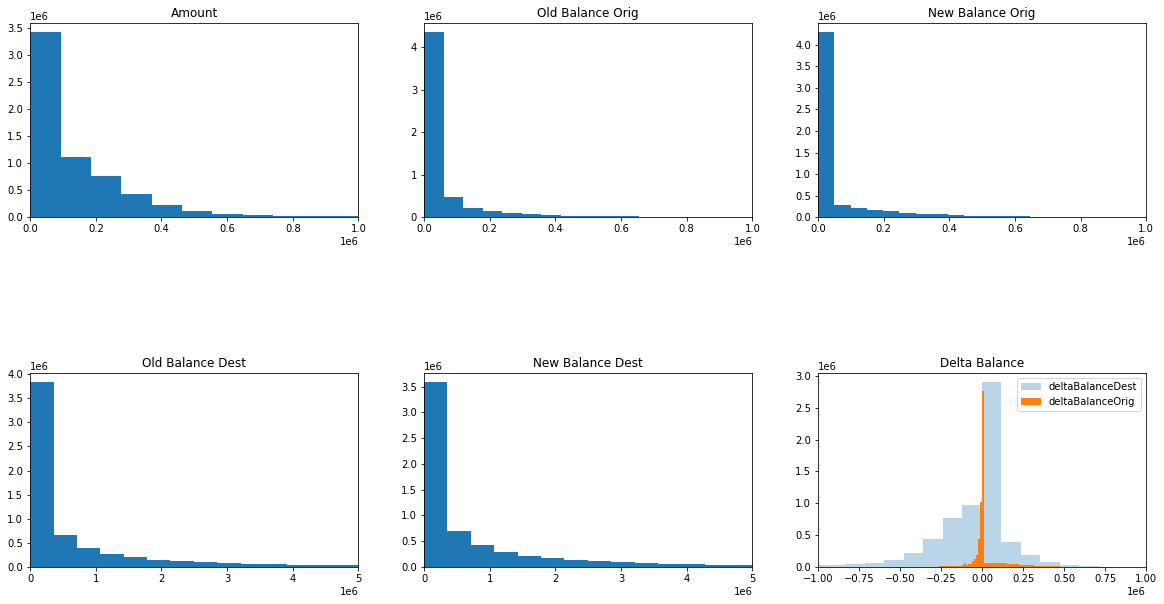

In [44]:
fig,((ax,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3)
fig.subplots_adjust(hspace=0.8)
ax.hist(x=data['amount'],bins=1000,label='amount')
ax.set_xlim(0,1e6)
ax.set_title('Amount')
ax1.hist(x=data['oldbalanceOrig'],bins=1000,label='oldbalanceOrig')
ax1.set_xlim(0,1e6)
ax1.set_title('Old Balance Orig')
ax2.hist(x=data['newbalanceOrig'],bins=1000,label='newbalanceOrig')
ax2.set_xlim(0,1e6)
ax2.set_title('New Balance Orig')
ax3.hist(x=data['oldbalanceDest'],bins=1000,label='oldbalanceDest')
ax3.set_xlim(0,0.5e7)
ax3.set_title('Old Balance Dest')
ax4.hist(x=data['newbalanceDest'],bins=1000,label='newbalanceDest')
ax4.set_xlim(0,0.5e7)
ax4.set_title('New Balance Dest')
ax5.hist(x=data['deltaBalanceDest'],bins=1000,label='deltaBalanceDest',alpha=0.3)
ax5.hist(x=data['deltaBalanceOrig'],bins=1000,label='deltaBalanceOrig')
ax5.set_xlim(-1e6,1e6)
ax5.set_title('Delta Balance')
ax5.legend()

plt.show()

In [45]:
features = data.loc[:,['amount','deltaBalanceDest','step','prevStep','type',
                       'oldbalanceOrig','newbalanceOrig','newbalanceDest',
                       'oldbalanceDest','deltaBalanceOrig','prevAmt','prevType',
                       'nameOrig','nameDest']]
features

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,prevType,nameOrig,nameDest
0,9839.64,0.00,1,NaN,PAYMENT,170136.00,160296.36,0.00,0.00,-9839.64,NaN,0,C1231006815,M1979787155
1,1864.28,0.00,1,1.0,PAYMENT,21249.00,19384.72,0.00,0.00,-1864.28,9839.64,0,C1666544295,M2044282225
2,181.00,0.00,1,1.0,TRANSFER,181.00,0.00,0.00,0.00,-181.00,1864.28,0,C1305486145,C553264065
3,181.00,21182.00,1,1.0,CASH_OUT,181.00,0.00,0.00,21182.00,-181.00,181.00,0,C840083671,C38997010
4,11668.14,0.00,1,1.0,PAYMENT,41554.00,29885.86,0.00,0.00,-11668.14,181.00,0,C2048537720,M1230701703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351188,162326.52,0.00,699,699.0,TRANSFER,162326.52,0.00,0.00,0.00,-162326.52,573.88,0,C1557504343,C404511346
6351189,162326.52,-162326.52,699,699.0,CASH_OUT,162326.52,0.00,162326.52,0.00,-162326.52,162326.52,0,C1532317723,C446134087
6351190,2763398.31,0.00,699,699.0,TRANSFER,2763398.31,0.00,0.00,0.00,-2763398.31,162326.52,0,C577803442,C619602282
6351191,2763398.31,-2763398.31,699,699.0,CASH_OUT,2763398.31,0.00,3102913.66,339515.35,-2763398.31,2763398.31,0,C1491503658,C454424230


In [46]:
cat_scaler = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan).fit(features[
    ['type','nameOrig','nameDest']].values)
features[['type','nameOrig','nameDest']] = cat_scaler.transform(features[['type','nameOrig','nameDest']].values)
features['prevType'] = features['type'].shift(1)
features['prevNameOrig'] = features['nameOrig'].shift(1)
features['prevNameDest'] = features['nameDest'].shift(1)
features

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,prevType,nameOrig,nameDest,prevNameOrig,prevNameDest
0,9839.64,0.00,1,NaN,3.0,170136.00,160296.36,0.00,0.00,-9839.64,NaN,NaN,756432.0,1658347.0,NaN,NaN
1,1864.28,0.00,1,1.0,3.0,21249.00,19384.72,0.00,0.00,-1864.28,9839.64,3.0,2185056.0,1730065.0,756432.0,1658347.0
2,181.00,0.00,1,1.0,4.0,181.00,0.00,0.00,0.00,-181.00,1864.28,3.0,1000312.0,438228.0,2185056.0,1730065.0
3,181.00,21182.00,1,1.0,1.0,181.00,0.00,0.00,21182.00,-181.00,181.00,4.0,5817752.0,390383.0,1000312.0,438228.0
4,11668.14,0.00,1,1.0,3.0,41554.00,29885.86,0.00,0.00,-11668.14,181.00,1.0,3439787.0,826594.0,5817752.0,390383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351188,162326.52,0.00,699,699.0,4.0,162326.52,0.00,0.00,0.00,-162326.52,573.88,3.0,1827404.0,394697.0,2538758.0,2004082.0
6351189,162326.52,-162326.52,699,699.0,1.0,162326.52,0.00,162326.52,0.00,-162326.52,162326.52,4.0,1745078.0,406977.0,1827404.0,394697.0
6351190,2763398.31,0.00,699,699.0,4.0,2763398.31,0.00,0.00,0.00,-2763398.31,162326.52,1.0,4955293.0,457660.0,1745078.0,406977.0
6351191,2763398.31,-2763398.31,699,699.0,1.0,2763398.31,0.00,3102913.66,339515.35,-2763398.31,2763398.31,4.0,1610912.0,409341.0,4955293.0,457660.0


In [48]:
seed = 42
Xtrain,Xtest,ytrain,ytest = train_test_split(features,responseVar,test_size=0.2,stratify=responseVar, random_state=seed)

In [49]:
mdl = XGBClassifier(use_label_encoder=False,verbosity=2)
mdl.fit(Xtrain,ytrain)

[20:51:42] INFO: ../src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[20:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[20:51:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[20:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[20:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[20:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[20:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:59:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[20:59:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[20:59:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[20:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:59:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[20:59:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=2)

In [50]:
mdl.score(Xtrain,ytrain)

0.9999974414253702

In [51]:
preds = mdl.predict(Xtest)
acc = accuracy_score(ytest,preds)
f1 = f1_score(ytest,preds)
prec = precision_score(ytest,preds)
recall = recall_score(ytest,preds)
AUC = roc_auc_score(ytest,preds)
print(acc, f1, prec, recall, AUC)

0.9999724461302164 0.9886987407168226 0.9851994851994852 0.9922229423201555 0.9961024067348727


In [52]:
dump(mdl,'XGBoostModelAll.joblib')
dump(cat_scaler,'TypeScalerAll.joblib')

['TypeScalerAll.joblib']

In [11]:
print(np.c_[features.columns,mdl.feature_importances_])

[['amount' 0.029668495059013367]
 ['deltaBalanceDest' 0.058822326362133026]
 ['step' 0.015605793334543705]
 ['prevStep' 0.0027813490014523268]
 ['type' 0.10291613638401031]
 ['oldbalanceOrig' 0.058962296694517136]
 ['newbalanceOrig' 0.09766244888305664]
 ['newbalanceDest' 0.2449093461036682]
 ['oldbalanceDest' 0.00556464958935976]
 ['deltaBalanceOrig' 0.04447830840945244]
 ['prevAmt' 0.03144669160246849]
 ['prevType' 0.29938217997550964]
 ['nameOrig' 0.001296404399909079]
 ['nameDest' 0.0031853902619332075]
 ['prevNameOrig' 0.0016836306313052773]
 ['prevNameDest' 0.0016346104675903916]]


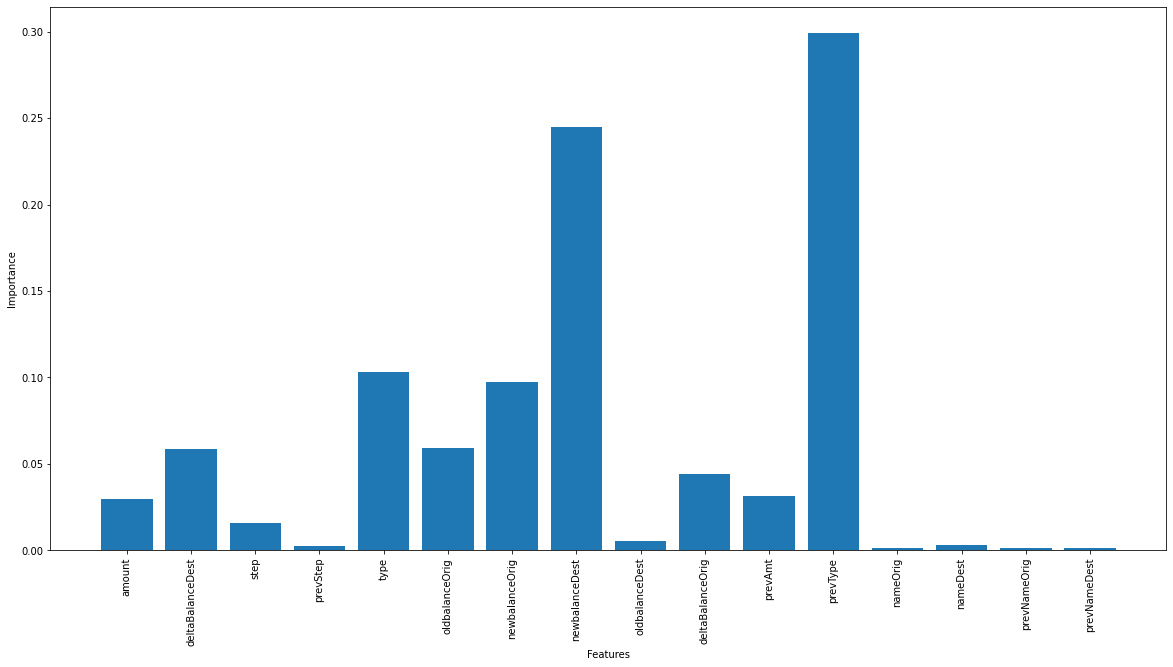

In [53]:
plt.bar(features.columns,mdl.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

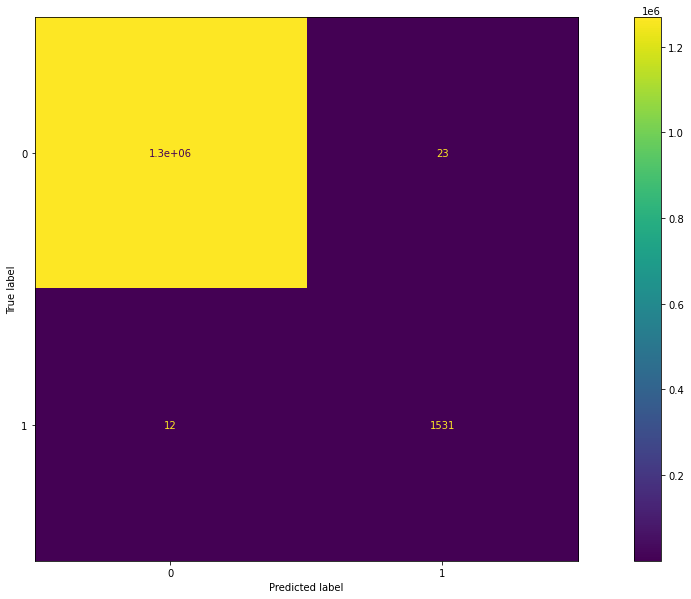

In [54]:
cm = confusion_matrix(ytest, preds, labels=mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mdl.classes_)
disp.plot()
plt.show()

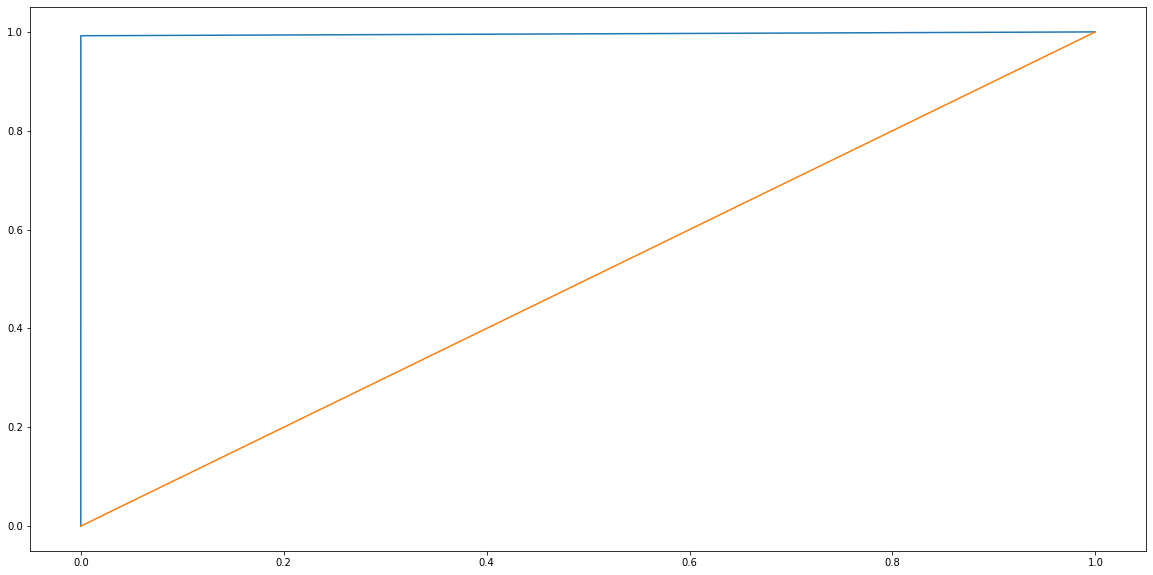

In [17]:
fpr, tpr, thresh = roc_curve(ytest,preds)
f, ax = plt.subplots(1)
ax.plot(fpr,tpr)
ax.plot([0,1])
plt.show()

In [24]:
w=cat_scaler.transform(features[['type','nameOrig','nameDest']])

In [31]:
X = features.loc[10,['type','nameOrig','nameDest']]
X

type              DEBIT
nameOrig    C1900366749
nameDest     C997608398
Name: 10, dtype: object

In [34]:
r = cat_scaler.transform(X.values.reshape(1,-1))

In [35]:
r

array([[2.000000e+00, 2.952632e+06, 5.693720e+05]])

In [36]:
r[0]

array([2.000000e+00, 2.952632e+06, 5.693720e+05])

In [37]:
Xtrain

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,prevType,nameOrig,nameDest,prevNameOrig,prevNameDest
4596184,10471.86,0.00,328,328.0,3.0,17488.00,7016.14,0.00,0.00,-10471.86,639059.59,4.0,1330462.0,2182751.0,5911410.0,164722.0
5540352,91525.09,-91525.08,382,382.0,1.0,0.00,0.00,6066022.93,5974497.85,0.00,36079.13,1.0,4323133.0,382148.0,6254792.0,72798.0
5703478,536642.44,-536642.44,398,398.0,1.0,40347.00,0.00,536642.44,0.00,-40347.00,70193.78,1.0,5811861.0,290200.0,892445.0,194211.0
4385897,60406.96,0.00,312,312.0,3.0,0.00,0.00,0.00,0.00,0.00,23948.53,3.0,4077873.0,2274090.0,5869254.0,1800761.0
6248873,31979.75,0.00,596,596.0,3.0,2018.32,0.00,0.00,0.00,-2018.32,6111.57,3.0,2615657.0,2248757.0,6326216.0,1446245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737207,305855.54,-305855.54,278,278.0,1.0,31982.00,0.00,2785021.40,2479165.86,-31982.00,88394.91,0.0,772169.0,460326.0,1370393.0,341353.0
1156007,251070.94,251070.94,131,131.0,0.0,17036127.95,17287198.90,153909.39,404980.33,251070.95,145657.63,0.0,4951241.0,118013.0,4615185.0,411466.0
413554,180125.26,-426920.66,18,18.0,1.0,21160.00,0.00,882640.75,455720.09,-21160.00,32108.20,1.0,622618.0,491820.0,5906439.0,182166.0
1717891,228791.24,-228791.25,160,160.0,1.0,0.00,0.00,12393116.73,12164325.48,0.00,21214.60,1.0,6208203.0,278101.0,5833274.0,72481.0


In [38]:
Xtest

,amount,deltaBalanceDest,step,prevStep,type,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,prevType,nameOrig,nameDest,prevNameOrig,prevNameDest
3566285,6401.18,0.00,260,260.0,3.0,228134.00,221732.82,0.00,0.00,-6401.18,199377.03,1.0,3241208.0,1198547.0,5059213.0,517642.0
93688,161307.22,-1097112.95,10,10.0,1.0,40068.00,0.00,1140934.55,43821.60,-40068.00,2136975.95,4.0,3131643.0,22491.0,3449737.0,424252.0
6105744,282176.18,-282176.18,525,525.0,4.0,548709.00,266532.82,282176.18,0.00,-282176.18,23251.70,3.0,4921143.0,275116.0,6285146.0,1477884.0
1162632,251078.44,-251078.44,132,132.0,1.0,133.00,0.00,251078.44,0.00,-133.00,497557.55,0.0,6225611.0,547542.0,1184075.0,532485.0
1519501,5523.21,0.00,153,153.0,3.0,19893.00,14369.79,0.00,0.00,-5523.21,378473.09,1.0,5017459.0,786923.0,167429.0,184414.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6260758,263974.68,263974.68,608,608.0,0.0,8691597.97,8955572.65,183869.53,447844.21,263974.68,271635.74,0.0,1907882.0,184601.0,5478873.0,399604.0
942816,248249.00,-248249.00,43,43.0,1.0,1017.00,0.00,2213640.95,1965391.95,-1017.00,175277.38,0.0,4893344.0,162603.0,217075.0,468643.0
6148111,299344.24,-299344.24,546,546.0,1.0,0.00,0.00,1463551.96,1164207.72,0.00,247519.79,1.0,2534374.0,506641.0,1253856.0,211832.0
3218539,213435.28,-25893.40,250,250.0,4.0,0.00,0.00,887818.03,861924.63,0.00,1197603.10,4.0,2812531.0,352629.0,638497.0,503968.0


In [39]:
c = np.array(["PAYMENT","C1231006815","M1979787155"])

In [47]:
r = cat_scaler.transform(np.array(["PAYMENT","C1231006815","M1979787155"]).reshape(1,-1))
r

array([[3.000000e+00, 7.564320e+05, 1.658347e+06]])